In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

In [3]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    
    model.add(Dense(128, input_dim = z_dim))
    
    model.add(LeakyReLU(alpha = 0.01))
    
    model.add(Dense(28 * 28 * 1, activation = 'tanh'))
    
    model.add(Reshape(img_shape))
    
    return model

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Flatten(input_shape = img_shape))
    
    model.add(Dense(128))
    
    model.add(LeakyReLU(alpha = 0.01))
    
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [10]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    
    (X_train, _), (_, _) = mnist.load_data()
    
    X_train = X_train /127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
    
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
    
        g_loss = gan.train_on_batch(z, real)
    
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
        
            print("%d [D loss: %f, acc.: %2f%%] [G loss: %f]" % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            sample_images(generator)

In [11]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    gen_imgs = generator.predict(z)
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4,4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

1000 [D loss: 0.018771, acc.: 100.000000%] [G loss: 5.629610]
2000 [D loss: 0.066649, acc.: 98.046875%] [G loss: 6.238298]
3000 [D loss: 0.157335, acc.: 94.140625%] [G loss: 4.320233]
4000 [D loss: 0.234857, acc.: 92.187500%] [G loss: 5.124547]
5000 [D loss: 0.166804, acc.: 93.750000%] [G loss: 5.101331]
6000 [D loss: 0.195997, acc.: 91.796875%] [G loss: 4.517946]
7000 [D loss: 0.386570, acc.: 86.328125%] [G loss: 4.020708]
8000 [D loss: 0.435628, acc.: 82.031250%] [G loss: 2.725624]
9000 [D loss: 0.308511, acc.: 89.062500%] [G loss: 4.710695]
10000 [D loss: 0.243256, acc.: 87.500000%] [G loss: 4.370809]
11000 [D loss: 0.408848, acc.: 82.421875%] [G loss: 3.206709]
12000 [D loss: 0.474050, acc.: 80.468750%] [G loss: 3.116552]
13000 [D loss: 0.238011, acc.: 88.671875%] [G loss: 3.983662]
14000 [D loss: 0.413736, acc.: 82.812500%] [G loss: 2.616446]
15000 [D loss: 0.465368, acc.: 80.859375%] [G loss: 2.729951]
16000 [D loss: 0.358464, acc.: 81.640625%] [G loss: 2.574015]
17000 [D loss: 0

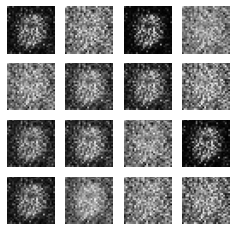

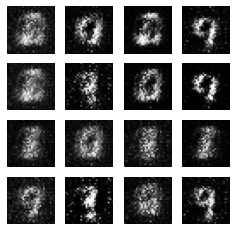

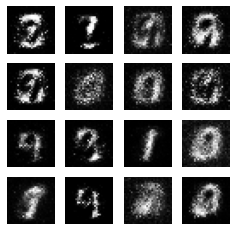

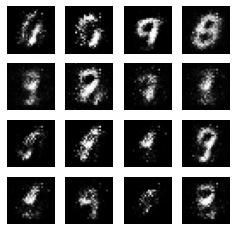

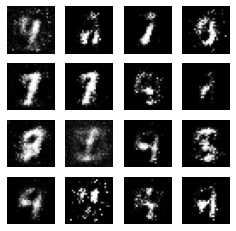

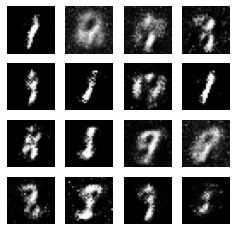

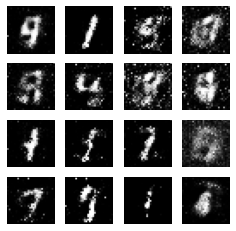

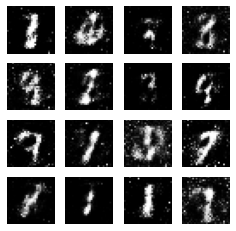

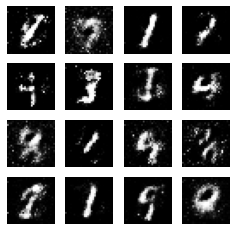

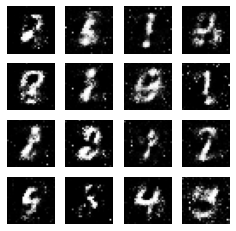

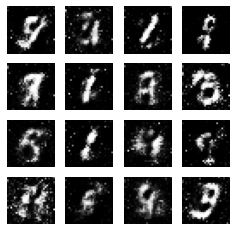

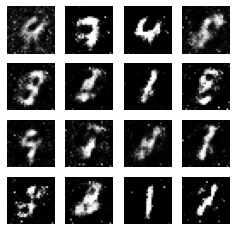

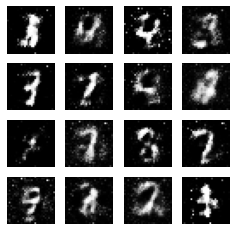

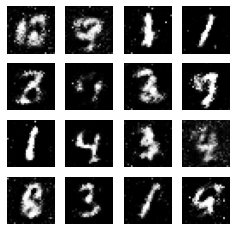

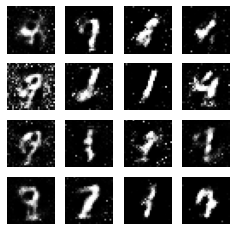

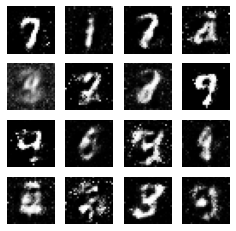

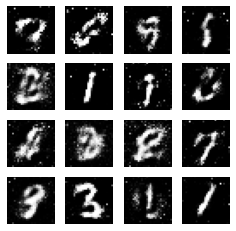

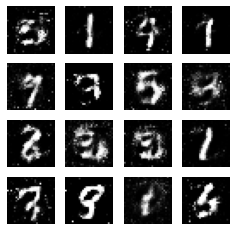

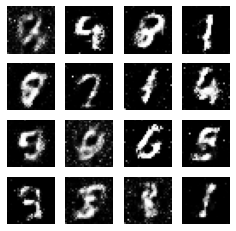

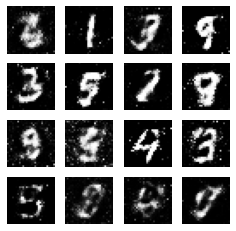

In [12]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)